### COLLABORATIVE FILTERING FOR IMPLICIT FEEDBACK

Import the necessary packages

In [1]:
import sys
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import seaborn as sns
import implicit
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")

Import the data of the last month as the test set and the one but last month to train the recommender system

In [2]:
# Load the data
traindata = pd.read_csv('Data/Processed/One_but_last_month_data_processsed_final.csv',encoding = 'unicode_escape')
testdata = pd.read_csv('Data/Processed/Last_month_data_processsed_final.csv',encoding = 'unicode_escape')

In [3]:
traindata_select = traindata.copy()
testdata_select = testdata.copy()
traindata_select.drop(columns=['no_of_accounts','province_segment','sex', 'age', 'new_customer_index','seniority','customer_type',
 'customer_relation_at_begin', 'foreign_index', 'province_name', 'activity_index', 'gross_income', 'segmentation'],inplace=True)
testdata_select.drop(columns=['no_of_accounts', 'province_segment', 'sex', 'age', 'new_customer_index', 'seniority', 'customer_type',
 'customer_relation_at_begin', 'foreign_index', 'province_name', 'activity_index', 'gross_income', 'segmentation'],inplace=True)
traindata_select=traindata_select.sort_values(by='customer_code')
testdata_select=testdata_select.sort_values(by='customer_code')
testdata_select=testdata_select.set_index('customer_code')
traindata_select=traindata_select.set_index('customer_code')
newpurchases = (testdata_select-traindata_select).clip(lower=0)
newpurchases = newpurchases[newpurchases.sum(axis=1) > 0]
newpurchasecust = newpurchases.index.tolist()
newpurchasecust = newpurchasecust[0:10000]
len(newpurchasecust)

10000

Subset the data to a sample for quick processing and make copies of the dataframe for future use

In [4]:
traindata=traindata.sort_values(by='customer_code')
testdata=testdata.sort_values(by='customer_code')
traindata=traindata[traindata['customer_code'].isin(newpurchasecust)]
testdata=testdata[testdata['customer_code'].isin(newpurchasecust)]
ncustomers=len(newpurchasecust)

In [5]:
traindata_copy = traindata.copy()
testdata_copy = testdata.copy()

Drop the demographic data columns, as Collaborative filtering algorithms only require a USER-ITEM interation matrix

In [6]:
#Drop demographic columns
traindata.drop(columns=['no_of_accounts',
 'province_segment',
 'sex',
 'age',
 'new_customer_index',
 'seniority',
 'customer_type',
 'customer_relation_at_begin',
 'foreign_index',
 'province_name',
 'activity_index',
 'gross_income',
 'segmentation'],inplace=True)

In [7]:
traindata_orig = traindata.copy()

Create transactions from the USER-ITEM matrix and remove records with accounts not owned by user

In [8]:
#Stack the data into transactions
traindata=traindata.set_index('customer_code')

traindata = traindata.stack()
traindata=traindata.to_frame()
traindata.reset_index(inplace=True)
traindata.columns = ['customer_code', 'account','ownership']
traindata=traindata[traindata['ownership']>0]
traindata.head()

,customer_code,account,ownership
2,15889,ind_current_account,1
7,15889,ind_particular_plus_account,1
18,15889,ind_securities,1
24,15929,ind_current_account,1
29,15929,ind_particular_plus_account,1


### COLLABORATIVE FILTERING FOR IMPLICIT FEEDBACK - ALTERNATING LEAST SQUARES

Create an ID for each USER and each ITEM as required by the IMPLICIT library for building the Recommender system

In [9]:
# Drop NaN columns
data = traindata.dropna()
data = data.copy()

# Create a numeric user_id and account_id column
data['customer_code'] = data['customer_code'].astype("category")
data['account'] = data['account'].astype("category")
data['customer_code_id'] = data['customer_code'].cat.codes
data['account_id'] = data['account'].cat.codes
data.head(10)

,customer_code,account,ownership,customer_code_id,account_id
2,15889,ind_current_account,1,0,1
7,15889,ind_particular_plus_account,1,0,15
18,15889,ind_securities,1,0,19
24,15929,ind_current_account,1,1,1
29,15929,ind_particular_plus_account,1,1,15
33,15929,ind_eaccount,1,1,4
39,15929,ind_credit_cards,1,1,0
40,15929,ind_securities,1,1,19
46,15952,ind_current_account,1,2,1
60,15952,ind_taxes,1,2,21


Create the USER-ITEM matrix and fit the ALS based implicit feedback collaborating filter model

In [10]:
# The implicit library expects data as a item-user matrix so we create two matricies, one for fitting the model (item-user) 
# and one for recommendations (user-item)
sparse_item_user = sparse.csr_matrix((data['ownership'].astype(float), (data['account_id'], data['customer_code_id'])))
sparse_user_item = sparse.csr_matrix((data['ownership'].astype(float), (data['customer_code_id'], data['account_id'])))

# Initialize the als model and fit it using the sparse item-user matrix
model = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.1, iterations=1000)

# Calculate the confidence by multiplying it by our alpha value.
alpha_val = 40
data_conf = (sparse_item_user * alpha_val).astype('double')

#Fit the model
model.fit(data_conf)

100%|██████████| 1000.0/1000 [00:10<00:00, 93.61it/s]


Create recommendations for each customer and pick the top recommended item by score

In [11]:
recommend_data = data
rec_item=[]
rec_item_2=[]
rec_item_3=[]
rec_item_4=[]
rec_item_5=[]

cust=[]
for i in tqdm(list(recommend_data['customer_code_id'].unique())):
    idx, score=model.recommend(i, sparse_user_item,filter_already_liked_items=True,N=5)[0]
    cust.append(i)
    rec_item.append(recommend_data.account.loc[recommend_data.account_id == idx].iloc[0])
    idx, score=model.recommend(i, sparse_user_item,filter_already_liked_items=True,N=5)[1]
    rec_item_2.append(recommend_data.account.loc[recommend_data.account_id == idx].iloc[0])
    idx, score=model.recommend(i, sparse_user_item,filter_already_liked_items=True,N=5)[2]
    rec_item_3.append(recommend_data.account.loc[recommend_data.account_id == idx].iloc[0])
    idx, score=model.recommend(i, sparse_user_item,filter_already_liked_items=True,N=5)[3]
    rec_item_4.append(recommend_data.account.loc[recommend_data.account_id == idx].iloc[0])
    idx, score=model.recommend(i, sparse_user_item,filter_already_liked_items=True,N=5)[4]
    rec_item_5.append(recommend_data.account.loc[recommend_data.account_id == idx].iloc[0])

100%|██████████| 10000/10000 [00:27<00:00, 362.88it/s]


In [12]:
rec_item_5[0:5]

['ind_mortgage',
 'ind_loans',
 'ind_particular_account',
 'ind_direct_debits',
 'ind_credit_cards']

Plot the most recommended items by the fit model

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

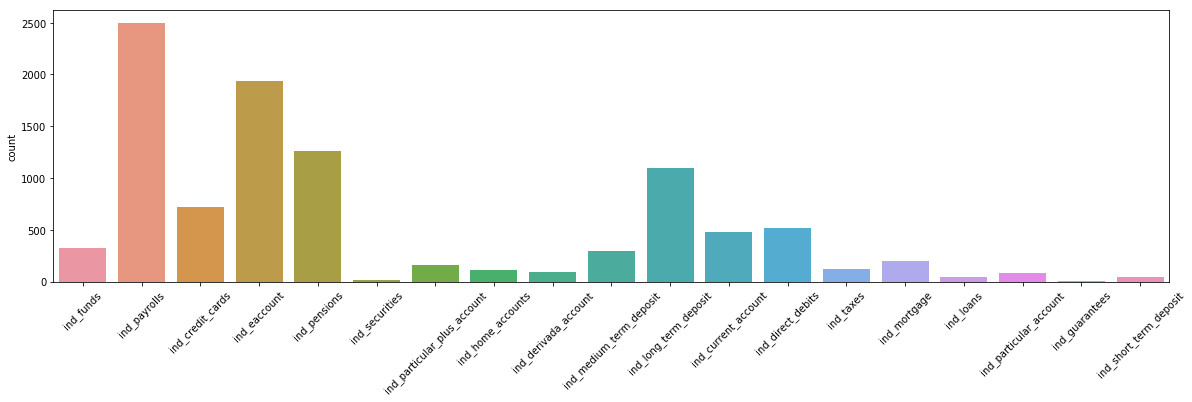

In [13]:
fig, ax = plt.subplots(figsize=(20,5))
sns.countplot(rec_item)
plt.xticks(rotation=45)

Create a USER-ITEM matrix with only the recommended items to prepare for scoring

In [14]:
recommendations=pd.DataFrame(list(zip(cust, rec_item)),columns=['customer_code_id','account'])
recommendations=pd.merge(recommendations,recommend_data[['customer_code','customer_code_id']],on='customer_code_id')
recommendations.drop(['customer_code_id'],axis=1,inplace=True)
recommendations['ownership']=1
recommendations=recommendations.pivot_table('ownership','customer_code','account')
recommendations=recommendations.reindex_axis(['ind_savings_account', 'ind_guarantees',
       'ind_current_account', 'ind_derivada_account', 'ind_junior_account',
       'ind_mas_particular_account', 'ind_particular_account',
       'ind_particular_plus_account', 'ind_short_term_deposit',
       'ind_medium_term_deposit', 'ind_long_term_deposit', 'ind_eaccount',
       'ind_funds', 'ind_mortgage', 'ind_pensions', 'ind_loans', 'ind_taxes',
       'ind_credit_cards', 'ind_securities', 'ind_home_accounts',
       'ind_payrolls', 'ind_direct_debits'], axis=1).fillna(0)
recommendations=recommendations.sort_index()
recommendations.head()

account,ind_savings_account,ind_guarantees,ind_current_account,ind_derivada_account,ind_junior_account,ind_mas_particular_account,ind_particular_account,ind_particular_plus_account,ind_short_term_deposit,ind_medium_term_deposit,...,ind_funds,ind_mortgage,ind_pensions,ind_loans,ind_taxes,ind_credit_cards,ind_securities,ind_home_accounts,ind_payrolls,ind_direct_debits
customer_code,,,,,,,,,,,,,,,,,,,,,
15889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
15952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
15988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
recommendations_mat = recommendations.values
D=recommendations_mat

Negate the already owned accounts in the one but last month and identify the newly added accounts in the last month data for scoring, at this point, the accounts held in one but last month but deactivated in the last month are also ignored.

In [16]:
acct_cols=['ind_savings_account', 'ind_guarantees', 'ind_current_account', 'ind_derivada_account', 'ind_junior_account',
 'ind_mas_particular_account', 'ind_particular_account', 'ind_particular_plus_account', 'ind_short_term_deposit',
 'ind_medium_term_deposit', 'ind_long_term_deposit', 'ind_eaccount', 'ind_funds',
 'ind_mortgage', 'ind_pensions', 'ind_loans', 'ind_taxes', 'ind_credit_cards', 'ind_securities', 
'ind_home_accounts', 'ind_payrolls', 'ind_direct_debits']

In [17]:
traindata_orig=traindata_orig.sort_values(by='customer_code')
testdata=testdata.sort_values(by='customer_code')
A=traindata_orig[acct_cols].values
B=testdata[acct_cols].values
C=B-A
C=C.clip(min=0)

Compare the predictions product by product and create the confusion matrix and print the scores

In [18]:
tn_tot=0
fp_tot=0
fn_tot=0
tp_tot=0
for i in range(0,22):
    x=confusion_matrix(C[:,i],D[:,i])
    if x.shape[0]==2:
        tn, fp, fn, tp = x.ravel()
        tn_tot+=tn
        fp_tot+=fp
        fn_tot+=fn
        tp_tot+=tp
    else:
        tn_tot += np.sum(x)

In [19]:
print('Results of COLLABORATIVE FILTERING FOR IMPLICIT FEEDBACK - ALTERNATING LEAST SQUARES \n')

#print('True Negatives = ',tn_tot)
print('True Positives = ',tp_tot)
print('False Negatives = ',fn_tot)
#print('False Positives = ',fp_tot)

recall = tp_tot / (tp_tot + fn_tot)

tp_tot_1 = tp_tot
fn_tot_1 = fn_tot
recall_1 = recall

precision_als = []
recall_als = []

precision_als.append(round((tp_tot/(ncustomers*1))*100,2))
recall_als.append(round(recall*100,2))

print('Precision = ',round((tp_tot/(ncustomers*1))*100,2),"%")
print('Recall = ',round(recall*100,2),"%")

Results of COLLABORATIVE FILTERING FOR IMPLICIT FEEDBACK - ALTERNATING LEAST SQUARES 

True Positives =  2328
False Negatives =  8493
Precision =  23.28 %
Recall =  21.51 %


### USER BASED COLLABORATIVE FILTERING FOR BINARY IMPLICIT FEEDBACK

Create a data item matrix from the original one but last month data

In [20]:
data_items=traindata_orig.copy()
data_items=data_items.drop(columns=['customer_code'])
data_items.columns

Index(['ind_savings_account', 'ind_guarantees', 'ind_current_account',
       'ind_derivada_account', 'ind_junior_account',
       'ind_mas_particular_account', 'ind_particular_account',
       'ind_particular_plus_account', 'ind_short_term_deposit',
       'ind_medium_term_deposit', 'ind_long_term_deposit', 'ind_eaccount',
       'ind_funds', 'ind_mortgage', 'ind_pensions', 'ind_loans', 'ind_taxes',
       'ind_credit_cards', 'ind_securities', 'ind_home_accounts',
       'ind_payrolls', 'ind_direct_debits'],
      dtype='object')

Build the USER-USER cosine similarity matrix for each USER pair in the input data (MEMORY INTENSIVE)

In [21]:
#------------------------
# USER_USER CALCULATIONS
#------------------------

# Normalize the user vectors to unit vectors.
# Magnitude = sqrt(x2 + y2 + z2 + ...)
magnitude = np.sqrt(np.square(data_items).sum(axis=1))

# Unit Vector = (x / magnitude, y / magnitude, z / magnitude, ...)
data_items = data_items.divide(magnitude, axis='index')

#Function to calculate cosine similarity using a SPARSE matrix
data_items_sparse = sparse.csr_matrix(data_items)
similarity = data_items_sparse.dot(data_items_sparse.T).toarray()
# squared magnitude of preference vectors (number of occurrences)
square_mag = np.diag(similarity)
# inverse squared magnitude
inv_square_mag = 1 / square_mag
# if it doesn't occur, set it's inverse magnitude to zero (instead of inf)
inv_square_mag[np.isinf(inv_square_mag)] = 0
# inverse of the magnitude
inv_mag = np.sqrt(inv_square_mag)
# cosine similarity (elementwise multiply by inverse magnitudes)
cosine = similarity * inv_mag
cosine = cosine.T * inv_mag

data_matrix= pd.DataFrame(data=cosine, index= data_items.index, columns= data_items.index)

# Get the top 5 similar users for 302413
print(data_matrix.loc[302413].nlargest(5))

302413    1.0
177068    1.0
189095    1.0
188786    1.0
159578    1.0
Name: 302413, dtype: float64


Creating recommendations for a sample user

In [22]:
#---------------------------------------------------------
# USER-ITEM CALCULATIONS - SAMPLE PREDICTION FOR ONE USER
#---------------------------------------------------------
user = 15889
user_index = traindata_orig[traindata_orig.customer_code == user].index.tolist()

#Construct a new dataframe with the 500 closest users (most similar) for each user.
data_neighbours = pd.DataFrame(index=user_index, columns=range(1,500))

data_neighbours.iloc[0,:499] = data_matrix.ix[:,user_index].sort_values(by=user_index,ascending=False)[:499].index

In [23]:
# Get the accounts the user owns already
known_user_likes=data_items.ix[user_index[0]]>0
known_user_likes = known_user_likes[known_user_likes == True].index.values
known_user_likes

array(['ind_current_account', 'ind_particular_plus_account',
       'ind_securities'], dtype=object)

In [24]:
# Construct the neighbourhood from the most similar items to the
# ones our user has already liked.
most_similar_to_likes = data_neighbours.ix[user_index]
similar_list = most_similar_to_likes.values.tolist()
similar_list = list(set([item for sublist in similar_list for item in sublist]))
neighbourhood = data_matrix[user_index].ix[similar_list]
similar_user_likes=data_items[data_items.index.isin(similar_list)]
similar_user_likes.sort_index(inplace=True)
similar_user_likes.head()

,ind_savings_account,ind_guarantees,ind_current_account,ind_derivada_account,ind_junior_account,ind_mas_particular_account,ind_particular_account,ind_particular_plus_account,ind_short_term_deposit,ind_medium_term_deposit,...,ind_funds,ind_mortgage,ind_pensions,ind_loans,ind_taxes,ind_credit_cards,ind_securities,ind_home_accounts,ind_payrolls,ind_direct_debits
12190,0.0,0.0,0.577350,0.0,0.0,0.0,0.0,0.577350,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.00000,0.0
12784,0.0,0.0,0.577350,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.57735,0.0,0.00000,0.0
13513,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.577350,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.57735,0.0,0.57735,0.0
15648,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.00000,0.0
16878,0.0,0.0,0.577350,0.0,0.0,0.0,0.0,0.577350,0.0,0.0,...,0.0,0.0,0.0,0.0,0.57735,0.0,0.00000,0.0,0.00000,0.0


In [25]:
# Calculate the score
score = similar_user_likes.mul(neighbourhood.T.values[0].tolist(),axis=0)
score = score.div(neighbourhood.sum(axis=1).T.values.tolist(),axis=0).sum()
account = score.drop(known_user_likes).sort_values(ascending=False).index[0]

Print the accounts owned by user already and the top 5 predictions by score for the selected user

In [26]:
print('The selected user is : ',user,'\n')
print('The accounts owned by user already are : ', known_user_likes,'\n')
print('Top 5 recommendations for the user :\n\n', score.drop(known_user_likes).nlargest(5))

The selected user is :  15889 

The accounts owned by user already are :  ['ind_current_account' 'ind_particular_plus_account' 'ind_securities'] 

Top 5 recommendations for the user :

 ind_particular_account    61.690064
ind_eaccount              30.185108
ind_direct_debits         27.065356
ind_taxes                 22.488597
ind_credit_cards          12.652146
dtype: float64


Looping above process and creating top 5 recommendations for all users

In [27]:
pred_user = []
pred_acc = []
pred_acc2 = []
pred_acc3 = []
pred_acc4 = []
pred_acc5 = []

for user in tqdm(traindata_orig['customer_code'].tolist()):
    user_index = traindata_orig[traindata_orig.customer_code == user].index.tolist()
    data_neighbours = pd.DataFrame(index=user_index, columns=range(1,1000))
    data_neighbours.iloc[0,:999] = data_matrix.ix[:,user_index].sort_values(by=user_index,ascending=False)[:999].index
    known_user_likes=data_items.ix[user_index[0]]>0
    known_user_likes = known_user_likes[known_user_likes == True].index.values
    most_similar_to_likes = data_neighbours.ix[user_index]
    similar_list = most_similar_to_likes.values.tolist()
    similar_list = list(set([item for sublist in similar_list for item in sublist]))
    neighbourhood = data_matrix[user_index].ix[similar_list]
    similar_user_likes=data_items[data_items.index.isin(similar_list)]
    similar_user_likes.sort_index(inplace=True)
    score = similar_user_likes.mul(neighbourhood.T.values[0].tolist(),axis=0)
    score = score.div(neighbourhood.sum(axis=1).T.values.tolist(),axis=0).sum()
    account = score.drop(known_user_likes).sort_values(ascending=False).index[0]
    account2 = score.drop(known_user_likes).sort_values(ascending=False).index[1]
    account3 = score.drop(known_user_likes).sort_values(ascending=False).index[2]
    account4 = score.drop(known_user_likes).sort_values(ascending=False).index[3]
    account5 = score.drop(known_user_likes).sort_values(ascending=False).index[4]
    pred_user.append(user)
    pred_acc.append(account)
    pred_acc2.append(account2)
    pred_acc3.append(account3)
    pred_acc4.append(account4)
    pred_acc5.append(account5)

100%|██████████| 10000/10000 [11:41<00:00, 14.26it/s]


Plot the most recommended items for all users by the model

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

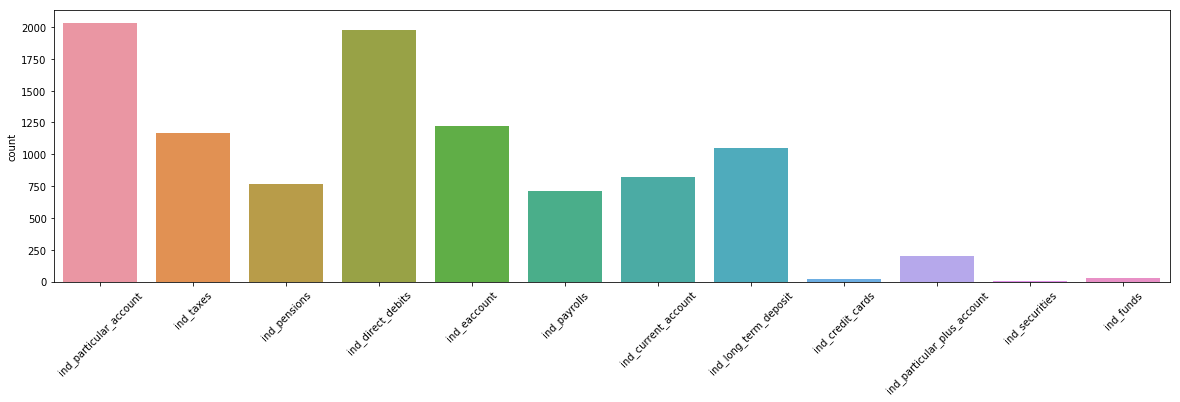

In [28]:
fig, ax = plt.subplots(figsize=(20,5))
sns.countplot(pred_acc)
plt.xticks(rotation=45)

Collate the predictions for each user and prepare for scoring

In [29]:
recommendations_uu=pd.DataFrame(list(zip(pred_user, pred_acc)),columns=['customer_code','account'])
recommendations_uu['ownership']=1
recommendations_uu=recommendations_uu.pivot_table('ownership','customer_code','account')
recommendations_uu=recommendations_uu.reindex_axis(['ind_savings_account', 'ind_guarantees',
       'ind_current_account', 'ind_derivada_account', 'ind_junior_account',
       'ind_mas_particular_account', 'ind_particular_account',
       'ind_particular_plus_account', 'ind_short_term_deposit',
       'ind_medium_term_deposit', 'ind_long_term_deposit', 'ind_eaccount',
       'ind_funds', 'ind_mortgage', 'ind_pensions', 'ind_loans', 'ind_taxes',
       'ind_credit_cards', 'ind_securities', 'ind_home_accounts',
       'ind_payrolls', 'ind_direct_debits'], axis=1).fillna(0)
recommendations_uu=recommendations_uu.sort_index()
recommendations_uu_mat = recommendations_uu.values
J=recommendations_uu_mat

Compare the predictions product by product and create the confusion matrix and print the scores

In [30]:
tn_tot=0
fp_tot=0
fn_tot=0
tp_tot=0
for i in range(0,22):
    x=confusion_matrix(C[:,i],J[:,i])
    if x.shape[0]==2:
        tn, fp, fn, tp = x.ravel()
        tn_tot+=tn
        fp_tot+=fp
        fn_tot+=fn
        tp_tot+=tp
    else:
        tn_tot += np.sum(x)

In [31]:
print('Results of USER-USER BASED COLLABORATIVE FILTERING FOR BINARY IMPLICIT FEEDBACK \n')
#print('True Negatives = ',tn_tot)
print('True Positives = ',tp_tot)
print('False Negatives = ',fn_tot)
#print('False Positives = ',fp_tot)

recall = tp_tot / (tp_tot + fn_tot)

tp_tot_2 = tp_tot
fn_tot_2 = fn_tot
recall_2 = recall

precision_uu = []
recall_uu = []

precision_uu.append(round((tp_tot/(ncustomers*1))*100,2))
recall_uu.append(round(recall*100,2))

print('Precision = ',round((tp_tot/(ncustomers*1))*100,2),"%")
print('Recall = ',round(recall*100,2),"%")

Results of USER-USER BASED COLLABORATIVE FILTERING FOR BINARY IMPLICIT FEEDBACK 

True Positives =  3149
False Negatives =  7672
Precision =  31.49 %
Recall =  29.1 %


### USER BASED COLLABORATIVE FILTERING FOR BINARY IMPLICIT FEEDBACK ENHANCED BY DEMOGRAPHIC CORRELATIONS

Create a copy of the original train data bin the continuous and one hot encode all the categorical demographic features

Create a USER-ITEM matrix and a USER-DEMOGRAPHIC MATRIX

In [32]:
data_items=traindata_orig.copy()
data_items=data_items.drop(columns=['customer_code'])

data_users=traindata_copy.copy()
data_users.drop(columns=acct_cols,inplace=True)
data_users.drop(columns=['customer_type',
                         'customer_relation_at_begin','activity_index','province_segment'],inplace=True)

data_users = data_users.assign(agebin = pd.qcut(data_users['age'],q=3,duplicates='drop'))
data_users = data_users.assign(senioritybin = pd.qcut(data_users['seniority'],q=3,duplicates='drop'))
data_users = data_users.assign(incbin = pd.qcut(data_users['gross_income'],q=3,duplicates='drop'))
data_users = data_users.assign(accbin = pd.qcut(data_users['no_of_accounts'],q=3,duplicates='drop'))

data_users.drop(columns=['age','seniority','gross_income','no_of_accounts'],inplace=True)


# let's one hot encode the remaining categorical features
ohe_features = ['sex', 'agebin', 'new_customer_index','senioritybin', 
                'foreign_index','province_name','incbin','segmentation','accbin']
data_users = pd.get_dummies(data_users, 
                              drop_first=False,
                              columns=ohe_features)

data_users.drop(columns=['customer_code'],inplace=True)

Create two USER-USER cosine similarity matrices one based on the USER-ITEM interactions and one based on USER-DEMOGRAPHICS

In [33]:
#------------------------
# USER_USER CALCULATIONS
#------------------------

#Normalize the user vectors to unit vectors.

# magnitude = sqrt(x2 + y2 + z2 + ...)
magnitude = np.sqrt(np.square(data_items).sum(axis=1))
# unitvector = (x / magnitude, y / magnitude, z / magnitude, ...)
data_items = data_items.divide(magnitude, axis='index')
# magnitude = sqrt(x2 + y2 + z2 + ...)
magnitude = np.sqrt(np.square(data_users).sum(axis=1))
# unitvector = (x / magnitude, y / magnitude, z / magnitude, ...)
data_users = data_users.divide(magnitude, axis='index')

def calculate_similarity(data_items):
    """Calculate the column-wise cosine similarity for a sparse
    matrix. Return a new dataframe matrix with similarities.
    """
    data_sparse = sparse.csr_matrix(data_items)
    similarities = cosine_similarity(data_sparse)
    sim = pd.DataFrame(data=similarities, index= data_items.index, columns= data_items.index)
    return sim

# Build the similarity matrix
data_matrix = calculate_similarity(data_items)

data_matrix_demo = calculate_similarity(data_users)

# Get the top 5 similar users by products
print(data_matrix.loc[302413].nlargest(5))

# Get the top 5 similar users by demography
print(data_matrix_demo.loc[302413].nlargest(5))

302413    1.0
177068    1.0
189095    1.0
188786    1.0
159578    1.0
Name: 302413, dtype: float64
302413    1.0
295710    1.0
295756    1.0
295295    1.0
296314    1.0
Name: 302413, dtype: float64


Calculate the demography enhanced USER-USER correlation scores

In [34]:
data_matrix = data_matrix + (data_matrix * data_matrix_demo)

Create sample recommendations for a user

In [35]:
#------------------------
# USER-ITEM CALCULATIONS
#------------------------
user = 15889

user_index = traindata_orig[traindata_orig.customer_code == user].index.tolist()

#Construct a new dataframe with the 500 closest neighbours (most similar) for each user.
data_neighbours = pd.DataFrame(index=user_index, columns=range(1,500))

data_neighbours.iloc[0,:499] = data_matrix.ix[:,user_index].sort_values(by=user_index,ascending=False)[:499].index

In [36]:
# Get the accounts owned by the user.
known_user_likes=data_items.ix[user_index[0]]>0
known_user_likes = known_user_likes[known_user_likes == True].index.values
known_user_likes

array(['ind_current_account', 'ind_particular_plus_account',
       'ind_securities'], dtype=object)

In [37]:
# Construct the neighbourhood from the most similar users to the
# ones our user has already liked.
most_similar_to_likes = data_neighbours.ix[user_index]
similar_list = most_similar_to_likes.values.tolist()
similar_list = list(set([item for sublist in similar_list for item in sublist]))
neighbourhood = data_matrix[user_index].ix[similar_list]
similar_user_likes=data_items[data_items.index.isin(similar_list)]
similar_user_likes.sort_index(inplace=True)
similar_user_likes.head()

,ind_savings_account,ind_guarantees,ind_current_account,ind_derivada_account,ind_junior_account,ind_mas_particular_account,ind_particular_account,ind_particular_plus_account,ind_short_term_deposit,ind_medium_term_deposit,...,ind_funds,ind_mortgage,ind_pensions,ind_loans,ind_taxes,ind_credit_cards,ind_securities,ind_home_accounts,ind_payrolls,ind_direct_debits
12190,0.0,0.0,0.577350,0.0,0.0,0.0,0.0,0.577350,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0
13513,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.577350,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.57735,0.0,0.57735,0.0
14015,0.0,0.0,0.577350,0.0,0.0,0.0,0.0,0.577350,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0
15648,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0
17103,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0


In [38]:
# Calculate the score.
score = similar_user_likes.mul(neighbourhood.T.values[0].tolist(),axis=0)
score = score.div(neighbourhood.sum(axis=1).T.values.tolist(),axis=0).sum()
account = score.drop(known_user_likes).sort_values(ascending=False).index[0]

Print the top 5 predictions for the selected user

In [39]:
print('The selected user is : ',user,'\n')
print('The accounts owned by user already are : ', known_user_likes,'\n')
print('Top 5 recommendations for the user :\n\n', score.drop(known_user_likes).nlargest(5))

The selected user is :  15889 

The accounts owned by user already are :  ['ind_current_account' 'ind_particular_plus_account' 'ind_securities'] 

Top 5 recommendations for the user :

 ind_particular_account    60.516354
ind_eaccount              38.322308
ind_direct_debits         27.428048
ind_taxes                 23.099650
ind_long_term_deposit     16.183255
dtype: float64


Loop the above steps and create top 5 recommendations for each user

In [40]:
pred_user = []
pred_acct = []
pred_acct2 = []
pred_acct3 = []
pred_acct4 = []
pred_acct5 = []

for user in tqdm(traindata_orig['customer_code'].tolist()):
#for user in tqdm(traindata['customer_code'].tolist()):
    user_index = traindata_orig[traindata_orig.customer_code == user].index.tolist()
    data_neighbours = pd.DataFrame(index=user_index, columns=range(1,1000))
    data_neighbours.iloc[0,:999] = data_matrix.ix[:,user_index].sort_values(by=user_index,ascending=False)[:999].index
    known_user_likes=data_items.ix[user_index[0]]>0
    known_user_likes = known_user_likes[known_user_likes == True].index.values
    most_similar_to_likes = data_neighbours.ix[user_index]
    similar_list = most_similar_to_likes.values.tolist()
    similar_list = list(set([item for sublist in similar_list for item in sublist]))
    neighbourhood = data_matrix[user_index].ix[similar_list]
    similar_user_likes=data_items[data_items.index.isin(similar_list)]
    similar_user_likes.sort_index(inplace=True)
    score = similar_user_likes.mul(neighbourhood.T.values[0].tolist(),axis=0)
    score = score.div(neighbourhood.sum(axis=1).T.values.tolist(),axis=0).sum()
    account = score.drop(known_user_likes).sort_values(ascending=False).index[0]
    account2 = score.drop(known_user_likes).sort_values(ascending=False).index[1]
    account3 = score.drop(known_user_likes).sort_values(ascending=False).index[2]
    account4 = score.drop(known_user_likes).sort_values(ascending=False).index[3]
    account5 = score.drop(known_user_likes).sort_values(ascending=False).index[4]
    pred_user.append(user)
    pred_acct.append(account)
    pred_acct2.append(account2)
    pred_acct3.append(account3)
    pred_acct4.append(account4)
    pred_acct5.append(account5)

100%|██████████| 10000/10000 [15:34<00:00, 13.18it/s]


Plot the top recommended items for all users

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

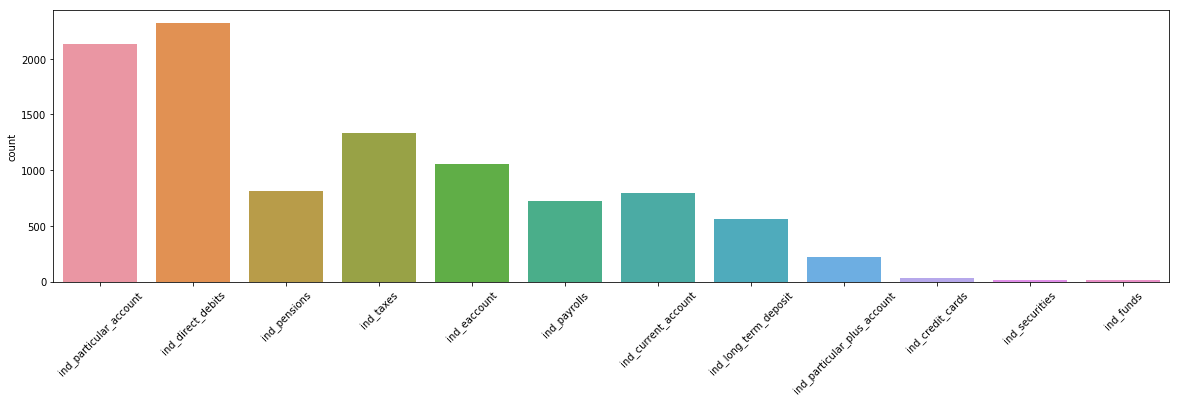

In [41]:
fig, ax = plt.subplots(figsize=(20,5))
sns.countplot(pred_acct)
plt.xticks(rotation=45)

Collate the predictions for each user and prepare for scoring

In [42]:
recommendations_uu=pd.DataFrame(list(zip(pred_user, pred_acct)),columns=['customer_code','account'])
recommendations_uu['ownership']=1
recommendations_uu=recommendations_uu.pivot_table('ownership','customer_code','account')
recommendations_uu=recommendations_uu.reindex_axis(['ind_savings_account', 'ind_guarantees',
       'ind_current_account', 'ind_derivada_account', 'ind_junior_account',
       'ind_mas_particular_account', 'ind_particular_account',
       'ind_particular_plus_account', 'ind_short_term_deposit',
       'ind_medium_term_deposit', 'ind_long_term_deposit', 'ind_eaccount',
       'ind_funds', 'ind_mortgage', 'ind_pensions', 'ind_loans', 'ind_taxes',
       'ind_credit_cards', 'ind_securities', 'ind_home_accounts',
       'ind_payrolls', 'ind_direct_debits'], axis=1).fillna(0)
recommendations_uu=recommendations_uu.sort_index()
recommendations_uu_mat = recommendations_uu.values
K=recommendations_uu_mat

In [43]:
tn_tot=0
fp_tot=0
fn_tot=0
tp_tot=0
for i in range(0,22):
    x=confusion_matrix(C[:,i],K[:,i])
    if x.shape[0]==2:
        tn, fp, fn, tp = x.ravel()
        tn_tot+=tn
        fp_tot+=fp
        fn_tot+=fn
        tp_tot+=tp
    else:
        tn_tot += np.sum(x)

Compare the predictions product by product and create the confusion matrix and print the scores

In [44]:
print('Results of USER BASED COLLABORATIVE FILTERING FOR IMPLICIT FEEDBACK WITH DEMOGRAPHIC CORRELATIONS \n')

#print('True Negatives = ',tn_tot)
print('True Positives = ',tp_tot)
print('False Negatives = ',fn_tot)
#print('False Positives = ',fp_tot)

recall = tp_tot / (tp_tot + fn_tot)

tp_tot_3 = tp_tot
fn_tot_3 = fn_tot
recall_3 = recall

precision_demo = []
recall_demo = []

precision_demo.append(round((tp_tot/(ncustomers*1))*100,2))
recall_demo.append(round(recall*100,2))

print('Precision = ',round((tp_tot/(ncustomers*1))*100,2),"%")
print('Recall = ',round(recall*100,2),"%")

Results of USER BASED COLLABORATIVE FILTERING FOR IMPLICIT FEEDBACK WITH DEMOGRAPHIC CORRELATIONS 

True Positives =  3435
False Negatives =  7386
Precision =  34.35 %
Recall =  31.74 %


### Result comparison

Precision and Recall @ K = 2

In [45]:
recommendations=pd.DataFrame(list(zip(cust, rec_item_2)),columns=['customer_code_id','account'])
recommendations=pd.merge(recommendations,recommend_data[['customer_code','customer_code_id']],on='customer_code_id')
recommendations.drop(['customer_code_id'],axis=1,inplace=True)
recommendations['ownership']=1
recommendations=recommendations.pivot_table('ownership','customer_code','account')
recommendations=recommendations.reindex_axis(['ind_savings_account', 'ind_guarantees',
       'ind_current_account', 'ind_derivada_account', 'ind_junior_account',
       'ind_mas_particular_account', 'ind_particular_account',
       'ind_particular_plus_account', 'ind_short_term_deposit',
       'ind_medium_term_deposit', 'ind_long_term_deposit', 'ind_eaccount',
       'ind_funds', 'ind_mortgage', 'ind_pensions', 'ind_loans', 'ind_taxes',
       'ind_credit_cards', 'ind_securities', 'ind_home_accounts',
       'ind_payrolls', 'ind_direct_debits'], axis=1).fillna(0)
recommendations=recommendations.sort_index()
recommendations_mat = recommendations.values
D+=recommendations_mat

tn_tot=0
fp_tot=0
fn_tot=0
tp_tot=0
for i in range(0,22):
    x=confusion_matrix(C[:,i],D[:,i])
    if x.shape[0]==2:
        tn, fp, fn, tp = x.ravel()
        tn_tot+=tn
        fp_tot+=fp
        fn_tot+=fn
        tp_tot+=tp
    else:
        tn_tot += np.sum(x)

print('Results of COLLABORATIVE FILTERING FOR IMPLICIT FEEDBACK - ALTERNATING LEAST SQUARES \n')

#print('True Negatives = ',tn_tot)
print('True Positives = ',tp_tot)
print('False Negatives = ',fn_tot)
#print('False Positives = ',fp_tot)

recall = tp_tot / (tp_tot + fn_tot)

precision_als.append(round((tp_tot/(ncustomers*2))*100,2))
recall_als.append(round(recall*100,2))

print('Precision = ',round((tp_tot/(ncustomers*2))*100,2),"%")
print('Recall = ',round(recall*100,2),"%")

Results of COLLABORATIVE FILTERING FOR IMPLICIT FEEDBACK - ALTERNATING LEAST SQUARES 

True Positives =  4755
False Negatives =  6066
Precision =  23.78 %
Recall =  43.94 %


In [46]:
recommendations_uu=pd.DataFrame(list(zip(pred_user, pred_acc2)),columns=['customer_code','account'])
recommendations_uu['ownership']=1
recommendations_uu=recommendations_uu.pivot_table('ownership','customer_code','account')
recommendations_uu=recommendations_uu.reindex_axis(['ind_savings_account', 'ind_guarantees',
       'ind_current_account', 'ind_derivada_account', 'ind_junior_account',
       'ind_mas_particular_account', 'ind_particular_account',
       'ind_particular_plus_account', 'ind_short_term_deposit',
       'ind_medium_term_deposit', 'ind_long_term_deposit', 'ind_eaccount',
       'ind_funds', 'ind_mortgage', 'ind_pensions', 'ind_loans', 'ind_taxes',
       'ind_credit_cards', 'ind_securities', 'ind_home_accounts',
       'ind_payrolls', 'ind_direct_debits'], axis=1).fillna(0)
recommendations_uu=recommendations_uu.sort_index()
recommendations_uu_mat = recommendations_uu.values
J+=recommendations_uu_mat

tn_tot=0
fp_tot=0
fn_tot=0
tp_tot=0
for i in range(0,22):
    x=confusion_matrix(C[:,i],J[:,i])
    if x.shape[0]==2:
        tn, fp, fn, tp = x.ravel()
        tn_tot+=tn
        fp_tot+=fp
        fn_tot+=fn
        tp_tot+=tp
    else:
        tn_tot += np.sum(x)
        
print('Results of USER-USER BASED COLLABORATIVE FILTERING FOR BINARY IMPLICIT FEEDBACK \n')
#print('True Negatives = ',tn_tot)
print('True Positives = ',tp_tot)
print('False Negatives = ',fn_tot)
#print('False Positives = ',fp_tot)

recall = tp_tot / (tp_tot + fn_tot)

precision_uu.append(round((tp_tot/(ncustomers*2))*100,2))
recall_uu.append(round(recall*100,2))

print('Precision = ',round((tp_tot/(ncustomers*2))*100,2),"%")
print('Recall = ',round(recall*100,2),"%")

Results of USER-USER BASED COLLABORATIVE FILTERING FOR BINARY IMPLICIT FEEDBACK 

True Positives =  5809
False Negatives =  5012
Precision =  29.04 %
Recall =  53.68 %


In [47]:
recommendations_uu=pd.DataFrame(list(zip(pred_user, pred_acct2)),columns=['customer_code','account'])
recommendations_uu['ownership']=1
recommendations_uu=recommendations_uu.pivot_table('ownership','customer_code','account')
recommendations_uu=recommendations_uu.reindex_axis(['ind_savings_account', 'ind_guarantees',
       'ind_current_account', 'ind_derivada_account', 'ind_junior_account',
       'ind_mas_particular_account', 'ind_particular_account',
       'ind_particular_plus_account', 'ind_short_term_deposit',
       'ind_medium_term_deposit', 'ind_long_term_deposit', 'ind_eaccount',
       'ind_funds', 'ind_mortgage', 'ind_pensions', 'ind_loans', 'ind_taxes',
       'ind_credit_cards', 'ind_securities', 'ind_home_accounts',
       'ind_payrolls', 'ind_direct_debits'], axis=1).fillna(0)
recommendations_uu=recommendations_uu.sort_index()
recommendations_uu_mat = recommendations_uu.values
K+=recommendations_uu_mat

tn_tot=0
fp_tot=0
fn_tot=0
tp_tot=0
for i in range(0,22):
    x=confusion_matrix(C[:,i],K[:,i])
    if x.shape[0]==2:
        tn, fp, fn, tp = x.ravel()
        tn_tot+=tn
        fp_tot+=fp
        fn_tot+=fn
        tp_tot+=tp
    else:
        tn_tot += np.sum(x)

print('Results of USER BASED COLLABORATIVE FILTERING FOR IMPLICIT FEEDBACK WITH DEMOGRAPHIC CORRELATIONS \n')

#print('True Negatives = ',tn_tot)
print('True Positives = ',tp_tot)
print('False Negatives = ',fn_tot)
#print('False Positives = ',fp_tot)

recall = tp_tot / (tp_tot + fn_tot)

precision_demo.append(round((tp_tot/(ncustomers*2))*100,2))
recall_demo.append(round(recall*100,2))

print('Precision = ',round((tp_tot/(ncustomers*2))*100,2),"%")
print('Recall = ',round(recall*100,2),"%")

Results of USER BASED COLLABORATIVE FILTERING FOR IMPLICIT FEEDBACK WITH DEMOGRAPHIC CORRELATIONS 

True Positives =  5784
False Negatives =  5037
Precision =  28.92 %
Recall =  53.45 %


Precision and Recall @ K = 3

In [48]:
recommendations=pd.DataFrame(list(zip(cust, rec_item_3)),columns=['customer_code_id','account'])
recommendations=pd.merge(recommendations,recommend_data[['customer_code','customer_code_id']],on='customer_code_id')
recommendations.drop(['customer_code_id'],axis=1,inplace=True)
recommendations['ownership']=1
recommendations=recommendations.pivot_table('ownership','customer_code','account')
recommendations=recommendations.reindex_axis(['ind_savings_account', 'ind_guarantees',
       'ind_current_account', 'ind_derivada_account', 'ind_junior_account',
       'ind_mas_particular_account', 'ind_particular_account',
       'ind_particular_plus_account', 'ind_short_term_deposit',
       'ind_medium_term_deposit', 'ind_long_term_deposit', 'ind_eaccount',
       'ind_funds', 'ind_mortgage', 'ind_pensions', 'ind_loans', 'ind_taxes',
       'ind_credit_cards', 'ind_securities', 'ind_home_accounts',
       'ind_payrolls', 'ind_direct_debits'], axis=1).fillna(0)
recommendations=recommendations.sort_index()
recommendations_mat = recommendations.values
D+=recommendations_mat

tn_tot=0
fp_tot=0
fn_tot=0
tp_tot=0
for i in range(0,22):
    x=confusion_matrix(C[:,i],D[:,i])
    if x.shape[0]==2:
        tn, fp, fn, tp = x.ravel()
        tn_tot+=tn
        fp_tot+=fp
        fn_tot+=fn
        tp_tot+=tp
    else:
        tn_tot += np.sum(x)

print('Results of COLLABORATIVE FILTERING FOR IMPLICIT FEEDBACK - ALTERNATING LEAST SQUARES \n')

#print('True Negatives = ',tn_tot)
print('True Positives = ',tp_tot)
print('False Negatives = ',fn_tot)
#print('False Positives = ',fp_tot)

recall = tp_tot / (tp_tot + fn_tot)

precision_als.append(round((tp_tot/(ncustomers*3))*100,2))
recall_als.append(round(recall*100,2))

print('Precision = ',round((tp_tot/(ncustomers*3))*100,2),"%")
print('Recall = ',round(recall*100,2),"%")

Results of COLLABORATIVE FILTERING FOR IMPLICIT FEEDBACK - ALTERNATING LEAST SQUARES 

True Positives =  5492
False Negatives =  5329
Precision =  18.31 %
Recall =  50.75 %


In [49]:
recommendations_uu=pd.DataFrame(list(zip(pred_user, pred_acc3)),columns=['customer_code','account'])
recommendations_uu['ownership']=1
recommendations_uu=recommendations_uu.pivot_table('ownership','customer_code','account')
recommendations_uu=recommendations_uu.reindex_axis(['ind_savings_account', 'ind_guarantees',
       'ind_current_account', 'ind_derivada_account', 'ind_junior_account',
       'ind_mas_particular_account', 'ind_particular_account',
       'ind_particular_plus_account', 'ind_short_term_deposit',
       'ind_medium_term_deposit', 'ind_long_term_deposit', 'ind_eaccount',
       'ind_funds', 'ind_mortgage', 'ind_pensions', 'ind_loans', 'ind_taxes',
       'ind_credit_cards', 'ind_securities', 'ind_home_accounts',
       'ind_payrolls', 'ind_direct_debits'], axis=1).fillna(0)
recommendations_uu=recommendations_uu.sort_index()
recommendations_uu_mat = recommendations_uu.values
J+=recommendations_uu_mat

tn_tot=0
fp_tot=0
fn_tot=0
tp_tot=0
for i in range(0,22):
    x=confusion_matrix(C[:,i],J[:,i])
    if x.shape[0]==2:
        tn, fp, fn, tp = x.ravel()
        tn_tot+=tn
        fp_tot+=fp
        fn_tot+=fn
        tp_tot+=tp
    else:
        tn_tot += np.sum(x)
        
print('Results of USER-USER BASED COLLABORATIVE FILTERING FOR BINARY IMPLICIT FEEDBACK \n')
#print('True Negatives = ',tn_tot)
print('True Positives = ',tp_tot)
print('False Negatives = ',fn_tot)
#print('False Positives = ',fp_tot)

recall = tp_tot / (tp_tot + fn_tot)

precision_uu.append(round((tp_tot/(ncustomers*3))*100,2))
recall_uu.append(round(recall*100,2))

print('Precision = ',round((tp_tot/(ncustomers*3))*100,2),"%")
print('Recall = ',round(recall*100,2),"%")

Results of USER-USER BASED COLLABORATIVE FILTERING FOR BINARY IMPLICIT FEEDBACK 

True Positives =  6964
False Negatives =  3857
Precision =  23.21 %
Recall =  64.36 %


In [50]:
recommendations_uu=pd.DataFrame(list(zip(pred_user, pred_acct3)),columns=['customer_code','account'])
recommendations_uu['ownership']=1
recommendations_uu=recommendations_uu.pivot_table('ownership','customer_code','account')
recommendations_uu=recommendations_uu.reindex_axis(['ind_savings_account', 'ind_guarantees',
       'ind_current_account', 'ind_derivada_account', 'ind_junior_account',
       'ind_mas_particular_account', 'ind_particular_account',
       'ind_particular_plus_account', 'ind_short_term_deposit',
       'ind_medium_term_deposit', 'ind_long_term_deposit', 'ind_eaccount',
       'ind_funds', 'ind_mortgage', 'ind_pensions', 'ind_loans', 'ind_taxes',
       'ind_credit_cards', 'ind_securities', 'ind_home_accounts',
       'ind_payrolls', 'ind_direct_debits'], axis=1).fillna(0)
recommendations_uu=recommendations_uu.sort_index()
recommendations_uu_mat = recommendations_uu.values
K+=recommendations_uu_mat

tn_tot=0
fp_tot=0
fn_tot=0
tp_tot=0
for i in range(0,22):
    x=confusion_matrix(C[:,i],K[:,i])
    if x.shape[0]==2:
        tn, fp, fn, tp = x.ravel()
        tn_tot+=tn
        fp_tot+=fp
        fn_tot+=fn
        tp_tot+=tp
    else:
        tn_tot += np.sum(x)

print('Results of USER BASED COLLABORATIVE FILTERING FOR IMPLICIT FEEDBACK WITH DEMOGRAPHIC CORRELATIONS \n')

#print('True Negatives = ',tn_tot)
print('True Positives = ',tp_tot)
print('False Negatives = ',fn_tot)
#print('False Positives = ',fp_tot)

recall = tp_tot / (tp_tot + fn_tot)

precision_demo.append(round((tp_tot/(ncustomers*3))*100,2))
recall_demo.append(round(recall*100,2))

print('Precision = ',round((tp_tot/(ncustomers*3))*100,2),"%")
print('Recall = ',round(recall*100,2),"%")

Results of USER BASED COLLABORATIVE FILTERING FOR IMPLICIT FEEDBACK WITH DEMOGRAPHIC CORRELATIONS 

True Positives =  7262
False Negatives =  3559
Precision =  24.21 %
Recall =  67.11 %


Precision and Recall @ K = 4

In [51]:
recommendations=pd.DataFrame(list(zip(cust, rec_item_4)),columns=['customer_code_id','account'])
recommendations=pd.merge(recommendations,recommend_data[['customer_code','customer_code_id']],on='customer_code_id')
recommendations.drop(['customer_code_id'],axis=1,inplace=True)
recommendations['ownership']=1
recommendations=recommendations.pivot_table('ownership','customer_code','account')
recommendations=recommendations.reindex_axis(['ind_savings_account', 'ind_guarantees',
       'ind_current_account', 'ind_derivada_account', 'ind_junior_account',
       'ind_mas_particular_account', 'ind_particular_account',
       'ind_particular_plus_account', 'ind_short_term_deposit',
       'ind_medium_term_deposit', 'ind_long_term_deposit', 'ind_eaccount',
       'ind_funds', 'ind_mortgage', 'ind_pensions', 'ind_loans', 'ind_taxes',
       'ind_credit_cards', 'ind_securities', 'ind_home_accounts',
       'ind_payrolls', 'ind_direct_debits'], axis=1).fillna(0)
recommendations=recommendations.sort_index()
recommendations_mat = recommendations.values
D+=recommendations_mat

tn_tot=0
fp_tot=0
fn_tot=0
tp_tot=0
for i in range(0,22):
    x=confusion_matrix(C[:,i],D[:,i])
    if x.shape[0]==2:
        tn, fp, fn, tp = x.ravel()
        tn_tot+=tn
        fp_tot+=fp
        fn_tot+=fn
        tp_tot+=tp
    else:
        tn_tot += np.sum(x)

print('Results of COLLABORATIVE FILTERING FOR IMPLICIT FEEDBACK - ALTERNATING LEAST SQUARES \n')

#print('True Negatives = ',tn_tot)
print('True Positives = ',tp_tot)
print('False Negatives = ',fn_tot)
#print('False Positives = ',fp_tot)

recall = tp_tot / (tp_tot + fn_tot)

precision_als.append(round((tp_tot/(ncustomers*4))*100,2))
recall_als.append(round(recall*100,2))

print('Precision = ',round((tp_tot/(ncustomers*4))*100,2),"%")
print('Recall = ',round(recall*100,2),"%")

Results of COLLABORATIVE FILTERING FOR IMPLICIT FEEDBACK - ALTERNATING LEAST SQUARES 

True Positives =  5987
False Negatives =  4834
Precision =  14.97 %
Recall =  55.33 %


In [52]:
recommendations_uu=pd.DataFrame(list(zip(pred_user, pred_acc4)),columns=['customer_code','account'])
recommendations_uu['ownership']=1
recommendations_uu=recommendations_uu.pivot_table('ownership','customer_code','account')
recommendations_uu=recommendations_uu.reindex_axis(['ind_savings_account', 'ind_guarantees',
       'ind_current_account', 'ind_derivada_account', 'ind_junior_account',
       'ind_mas_particular_account', 'ind_particular_account',
       'ind_particular_plus_account', 'ind_short_term_deposit',
       'ind_medium_term_deposit', 'ind_long_term_deposit', 'ind_eaccount',
       'ind_funds', 'ind_mortgage', 'ind_pensions', 'ind_loans', 'ind_taxes',
       'ind_credit_cards', 'ind_securities', 'ind_home_accounts',
       'ind_payrolls', 'ind_direct_debits'], axis=1).fillna(0)
recommendations_uu=recommendations_uu.sort_index()
recommendations_uu_mat = recommendations_uu.values
J+=recommendations_uu_mat

tn_tot=0
fp_tot=0
fn_tot=0
tp_tot=0
for i in range(0,22):
    x=confusion_matrix(C[:,i],J[:,i])
    if x.shape[0]==2:
        tn, fp, fn, tp = x.ravel()
        tn_tot+=tn
        fp_tot+=fp
        fn_tot+=fn
        tp_tot+=tp
    else:
        tn_tot += np.sum(x)
        
print('Results of USER-USER BASED COLLABORATIVE FILTERING FOR BINARY IMPLICIT FEEDBACK \n')
#print('True Negatives = ',tn_tot)
print('True Positives = ',tp_tot)
print('False Negatives = ',fn_tot)
#print('False Positives = ',fp_tot)

recall = tp_tot / (tp_tot + fn_tot)

precision_uu.append(round((tp_tot/(ncustomers*4))*100,2))
recall_uu.append(round(recall*100,2))

print('Precision = ',round((tp_tot/(ncustomers*4))*100,2),"%")
print('Recall = ',round(recall*100,2),"%")

Results of USER-USER BASED COLLABORATIVE FILTERING FOR BINARY IMPLICIT FEEDBACK 

True Positives =  8348
False Negatives =  2473
Precision =  20.87 %
Recall =  77.15 %


In [53]:
recommendations_uu=pd.DataFrame(list(zip(pred_user, pred_acct4)),columns=['customer_code','account'])
recommendations_uu['ownership']=1
recommendations_uu=recommendations_uu.pivot_table('ownership','customer_code','account')
recommendations_uu=recommendations_uu.reindex_axis(['ind_savings_account', 'ind_guarantees',
       'ind_current_account', 'ind_derivada_account', 'ind_junior_account',
       'ind_mas_particular_account', 'ind_particular_account',
       'ind_particular_plus_account', 'ind_short_term_deposit',
       'ind_medium_term_deposit', 'ind_long_term_deposit', 'ind_eaccount',
       'ind_funds', 'ind_mortgage', 'ind_pensions', 'ind_loans', 'ind_taxes',
       'ind_credit_cards', 'ind_securities', 'ind_home_accounts',
       'ind_payrolls', 'ind_direct_debits'], axis=1).fillna(0)
recommendations_uu=recommendations_uu.sort_index()
recommendations_uu_mat = recommendations_uu.values
K+=recommendations_uu_mat

tn_tot=0
fp_tot=0
fn_tot=0
tp_tot=0
for i in range(0,22):
    x=confusion_matrix(C[:,i],K[:,i])
    if x.shape[0]==2:
        tn, fp, fn, tp = x.ravel()
        tn_tot+=tn
        fp_tot+=fp
        fn_tot+=fn
        tp_tot+=tp
    else:
        tn_tot += np.sum(x)

print('Results of USER BASED COLLABORATIVE FILTERING FOR IMPLICIT FEEDBACK WITH DEMOGRAPHIC CORRELATIONS \n')

#print('True Negatives = ',tn_tot)
print('True Positives = ',tp_tot)
print('False Negatives = ',fn_tot)
#print('False Positives = ',fp_tot)

recall = tp_tot / (tp_tot + fn_tot)

precision_demo.append(round((tp_tot/(ncustomers*4))*100,2))
recall_demo.append(round(recall*100,2))

print('Precision = ',round((tp_tot/(ncustomers*4))*100,2),"%")
print('Recall = ',round(recall*100,2),"%")

Results of USER BASED COLLABORATIVE FILTERING FOR IMPLICIT FEEDBACK WITH DEMOGRAPHIC CORRELATIONS 

True Positives =  8389
False Negatives =  2432
Precision =  20.97 %
Recall =  77.53 %


Precision and Recall @ K = 5

In [54]:
recommendations=pd.DataFrame(list(zip(cust, rec_item_5)),columns=['customer_code_id','account'])
recommendations=pd.merge(recommendations,recommend_data[['customer_code','customer_code_id']],on='customer_code_id')
recommendations.drop(['customer_code_id'],axis=1,inplace=True)
recommendations['ownership']=1
recommendations=recommendations.pivot_table('ownership','customer_code','account')
recommendations=recommendations.reindex_axis(['ind_savings_account', 'ind_guarantees',
       'ind_current_account', 'ind_derivada_account', 'ind_junior_account',
       'ind_mas_particular_account', 'ind_particular_account',
       'ind_particular_plus_account', 'ind_short_term_deposit',
       'ind_medium_term_deposit', 'ind_long_term_deposit', 'ind_eaccount',
       'ind_funds', 'ind_mortgage', 'ind_pensions', 'ind_loans', 'ind_taxes',
       'ind_credit_cards', 'ind_securities', 'ind_home_accounts',
       'ind_payrolls', 'ind_direct_debits'], axis=1).fillna(0)
recommendations=recommendations.sort_index()
recommendations_mat = recommendations.values
D+=recommendations_mat

tn_tot=0
fp_tot=0
fn_tot=0
tp_tot=0
for i in range(0,22):
    x=confusion_matrix(C[:,i],D[:,i])
    if x.shape[0]==2:
        tn, fp, fn, tp = x.ravel()
        tn_tot+=tn
        fp_tot+=fp
        fn_tot+=fn
        tp_tot+=tp
    else:
        tn_tot += np.sum(x)

print('Results of COLLABORATIVE FILTERING FOR IMPLICIT FEEDBACK - ALTERNATING LEAST SQUARES \n')

#print('True Negatives = ',tn_tot)
print('True Positives = ',tp_tot)
print('False Negatives = ',fn_tot)
#print('False Positives = ',fp_tot)

recall = tp_tot / (tp_tot + fn_tot)

precision_als.append(round((tp_tot/(ncustomers*5))*100,2))
recall_als.append(round(recall*100,2))

print('Precision = ',round((tp_tot/(ncustomers*5))*100,2),"%")
print('Recall = ',round(recall*100,2),"%")

Results of COLLABORATIVE FILTERING FOR IMPLICIT FEEDBACK - ALTERNATING LEAST SQUARES 

True Positives =  7171
False Negatives =  3650
Precision =  14.34 %
Recall =  66.27 %


In [55]:
recommendations_uu=pd.DataFrame(list(zip(pred_user, pred_acc5)),columns=['customer_code','account'])
recommendations_uu['ownership']=1
recommendations_uu=recommendations_uu.pivot_table('ownership','customer_code','account')
recommendations_uu=recommendations_uu.reindex_axis(['ind_savings_account', 'ind_guarantees',
       'ind_current_account', 'ind_derivada_account', 'ind_junior_account',
       'ind_mas_particular_account', 'ind_particular_account',
       'ind_particular_plus_account', 'ind_short_term_deposit',
       'ind_medium_term_deposit', 'ind_long_term_deposit', 'ind_eaccount',
       'ind_funds', 'ind_mortgage', 'ind_pensions', 'ind_loans', 'ind_taxes',
       'ind_credit_cards', 'ind_securities', 'ind_home_accounts',
       'ind_payrolls', 'ind_direct_debits'], axis=1).fillna(0)
recommendations_uu=recommendations_uu.sort_index()
recommendations_uu_mat = recommendations_uu.values
J+=recommendations_uu_mat

tn_tot=0
fp_tot=0
fn_tot=0
tp_tot=0
for i in range(0,22):
    x=confusion_matrix(C[:,i],J[:,i])
    if x.shape[0]==2:
        tn, fp, fn, tp = x.ravel()
        tn_tot+=tn
        fp_tot+=fp
        fn_tot+=fn
        tp_tot+=tp
    else:
        tn_tot += np.sum(x)
        
print('Results of USER-USER BASED COLLABORATIVE FILTERING FOR BINARY IMPLICIT FEEDBACK \n')
#print('True Negatives = ',tn_tot)
print('True Positives = ',tp_tot)
print('False Negatives = ',fn_tot)
#print('False Positives = ',fp_tot)

recall = tp_tot / (tp_tot + fn_tot)

precision_uu.append(round((tp_tot/(ncustomers*5))*100,2))
recall_uu.append(round(recall*100,2))

print('Precision = ',round((tp_tot/(ncustomers*5))*100,2),"%")
print('Recall = ',round(recall*100,2),"%")

Results of USER-USER BASED COLLABORATIVE FILTERING FOR BINARY IMPLICIT FEEDBACK 

True Positives =  9384
False Negatives =  1437
Precision =  18.77 %
Recall =  86.72 %


In [56]:
recommendations_uu=pd.DataFrame(list(zip(pred_user, pred_acct5)),columns=['customer_code','account'])
recommendations_uu['ownership']=1
recommendations_uu=recommendations_uu.pivot_table('ownership','customer_code','account')
recommendations_uu=recommendations_uu.reindex_axis(['ind_savings_account', 'ind_guarantees',
       'ind_current_account', 'ind_derivada_account', 'ind_junior_account',
       'ind_mas_particular_account', 'ind_particular_account',
       'ind_particular_plus_account', 'ind_short_term_deposit',
       'ind_medium_term_deposit', 'ind_long_term_deposit', 'ind_eaccount',
       'ind_funds', 'ind_mortgage', 'ind_pensions', 'ind_loans', 'ind_taxes',
       'ind_credit_cards', 'ind_securities', 'ind_home_accounts',
       'ind_payrolls', 'ind_direct_debits'], axis=1).fillna(0)
recommendations_uu=recommendations_uu.sort_index()
recommendations_uu_mat = recommendations_uu.values
K+=recommendations_uu_mat

tn_tot=0
fp_tot=0
fn_tot=0
tp_tot=0
for i in range(0,22):
    x=confusion_matrix(C[:,i],K[:,i])
    if x.shape[0]==2:
        tn, fp, fn, tp = x.ravel()
        tn_tot+=tn
        fp_tot+=fp
        fn_tot+=fn
        tp_tot+=tp
    else:
        tn_tot += np.sum(x)

print('Results of USER BASED COLLABORATIVE FILTERING FOR IMPLICIT FEEDBACK WITH DEMOGRAPHIC CORRELATIONS \n')

#print('True Negatives = ',tn_tot)
print('True Positives = ',tp_tot)
print('False Negatives = ',fn_tot)
#print('False Positives = ',fp_tot)

recall = tp_tot / (tp_tot + fn_tot)

precision_demo.append(round((tp_tot/(ncustomers*5))*100,2))
recall_demo.append(round(recall*100,2))

print('Precision = ',round((tp_tot/(ncustomers*5))*100,2),"%")
print('Recall = ',round(recall*100,2),"%")

Results of USER BASED COLLABORATIVE FILTERING FOR IMPLICIT FEEDBACK WITH DEMOGRAPHIC CORRELATIONS 

True Positives =  9440
False Negatives =  1381
Precision =  18.88 %
Recall =  87.24 %


Plot the PRECISION @ K and RECALL @ K metrics to identify optimal

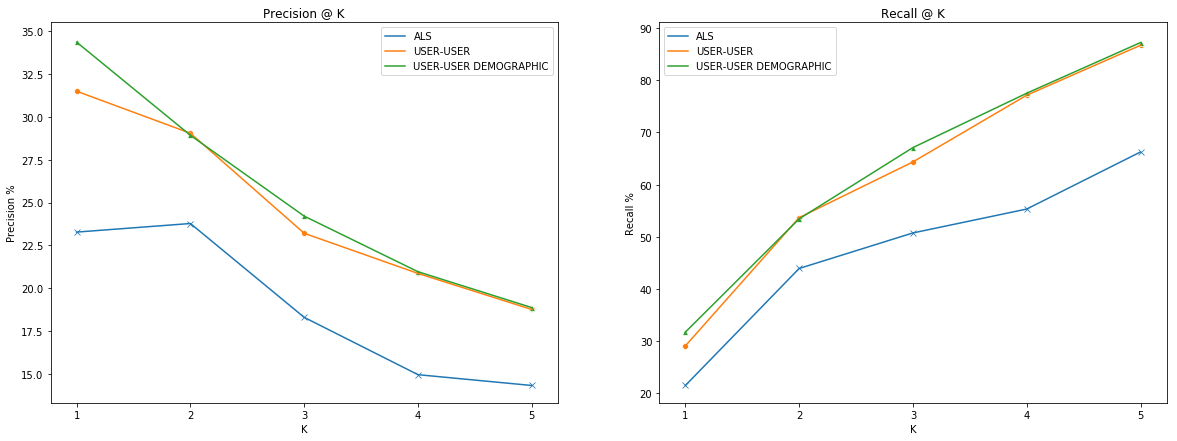

In [57]:
kpreds = [1,2,3,4,5]
fig,axes = plt.subplots(ncols=2 ,nrows=1)
fig.set_size_inches(20,7)
sns.scatterplot(x=kpreds,y=precision_als,marker="x",ax=axes[0]).set_title('Precision @ K')
sns.lineplot(x=kpreds,y=precision_als,markers=True,label='ALS',ax=axes[0])
sns.scatterplot(x=kpreds,y=precision_uu,marker="o",ax=axes[0])
sns.lineplot(x=kpreds,y=precision_uu,markers=True,label='USER-USER',ax=axes[0])
sns.scatterplot(x=kpreds,y=precision_demo,marker="^",ax=axes[0])
sns.lineplot(x=kpreds,y=precision_demo,markers=True,label='USER-USER DEMOGRAPHIC',ax=axes[0])
axes[0].set(xlabel='K',ylabel='Precision %')
axes[0].set_xticks(kpreds)

sns.scatterplot(x=kpreds,y=recall_als,marker="x",ax=axes[1]).set_title('Recall @ K')
sns.lineplot(x=kpreds,y=recall_als,markers=True,label='ALS',ax=axes[1])
sns.scatterplot(x=kpreds,y=recall_uu,marker="o",ax=axes[1])
sns.lineplot(x=kpreds,y=recall_uu,markers=True,label='USER-USER',ax=axes[1])
sns.scatterplot(x=kpreds,y=recall_demo,marker="^",ax=axes[1])
sns.lineplot(x=kpreds,y=recall_demo,markers=True,label='USER-USER DEMOGRAPHIC',ax=axes[1])
axes[1].set(xlabel='K',ylabel='Recall %')
axes[1].set_xticks(kpreds)

In [58]:
precision_als = np.divide(precision_als,100)
precision_uu = np.divide(precision_uu,100)
precision_demo = np.divide(precision_demo,100)

recall_als = np.divide(recall_als,100)
recall_uu = np.divide(recall_uu,100)
recall_demo = np.divide(recall_demo,100)

In [59]:
precision_als = [round(x,3) for x in precision_als]
precision_uu= [round(x,3) for x in precision_uu]
precision_demo= [round(x,3) for x in precision_demo]

recall_als = [round(x,2) for x in recall_als]
recall_uu= [round(x,2) for x in recall_uu]
recall_demo= [round(x,2) for x in recall_demo]

In [60]:
print('\n PRECISION @ K')
t = PrettyTable(['Model', 'K=1' , 'K=2', 'K=3', 'K=4', 'K=5'])
t.add_row(['IMPLICIT FB LATENT FACTORIZATION BY ALS', precision_als[0],precision_als[1],precision_als[2],precision_als[3],precision_als[4]])
t.add_row(['USER BASED CF FOR BINARY IMPLICIT FB', precision_uu[0],precision_uu[1],precision_uu[2],precision_uu[3],precision_uu[4]])
t.add_row(['USER BASED CF WITH DEMOGRAPHIC CORRELATION', precision_demo[0],precision_demo[1],precision_demo[2],precision_demo[3],precision_demo[4]])
print(t)

print('\n RECALL @ K')
t = PrettyTable(['Model', 'K=1' , 'K=2', 'K=3', 'K=4', 'K=5'])
t.add_row(['IMPLICIT FB LATENT FACTORIZATION BY ALS', recall_als[0],recall_als[1],recall_als[2],recall_als[3],recall_als[4]])
t.add_row(['USER BASED CF FOR BINARY IMPLICIT FB', recall_uu[0],recall_uu[1],recall_uu[2],recall_uu[3],recall_uu[4]])
t.add_row(['USER BASED CF WITH DEMOGRAPHIC CORRELATION', recall_demo[0],recall_demo[1],recall_demo[2],recall_demo[3],recall_demo[4]])
print(t)


 PRECISION @ K
+--------------------------------------------+-------+-------+-------+-------+-------+
|                   Model                    |  K=1  |  K=2  |  K=3  |  K=4  |  K=5  |
+--------------------------------------------+-------+-------+-------+-------+-------+
|  IMPLICIT FB LATENT FACTORIZATION BY ALS   | 0.233 | 0.238 | 0.183 |  0.15 | 0.143 |
|    USER BASED CF FOR BINARY IMPLICIT FB    | 0.315 |  0.29 | 0.232 | 0.209 | 0.188 |
| USER BASED CF WITH DEMOGRAPHIC CORRELATION | 0.344 | 0.289 | 0.242 |  0.21 | 0.189 |
+--------------------------------------------+-------+-------+-------+-------+-------+

 RECALL @ K
+--------------------------------------------+------+------+------+------+------+
|                   Model                    | K=1  | K=2  | K=3  | K=4  | K=5  |
+--------------------------------------------+------+------+------+------+------+
|  IMPLICIT FB LATENT FACTORIZATION BY ALS   | 0.22 | 0.44 | 0.51 | 0.55 | 0.66 |
|    USER BASED CF FOR BINARY IMPL